<h3>Forensics, project F3 </h3>
<h1>Experiments on high entropy files</h1>
<hr style="height:2px;border:none;color:#333;background-color:#333;"/>

_Author_
<div class="alert alert-warning">RAFFLIN Corentin </div>

<h2> 4) Observation phase </h2>

The results of the experiments are saved in a file named `results.csv`, this notebook focuses on the plotting of the distribution of the tests for each file type. 

References for most of the quoted text : 
* http://www.devttys0.com/2013/06/differentiate-encryption-from-compression-using-math/
* http://sgros.blogspot.com/2014/12/how-to-determine-if-some-blob-is.html
* http://www.fourmilab.ch/random/

<div class="">
    <h3>1. Loading and treating the data</h3>
</div>

In [1]:
#Diverses libraries
%matplotlib inline
import random
from time import time
import pickle

# Data and plotting imports
import matplotlib.colors as pltcolors
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

<h4> Loading the data </h4>

In [2]:
#Path to the CSV file
resultsPath = 'results.csv'

#Header to associate to the CSV file
tests = ['File_type','File_bytes','Entropy','Chi_square','Mean','Monte_Carlo_Pi','Serial_Correlation'] 
cols = tests + [str(i) for i in range(0,256)]

In [3]:
#Loading data
data = pd.read_csv(resultsPath, sep=',', header=None, names=cols)
print('There are {} files analyzed'.format(len(data)))

There are 6220 files analyzed


<h4> Removing outliers and balancing the data </h4>

In [4]:
countBefore = data['File_type'].value_counts().to_frame().rename(index=str, columns={'File_type':'Count_before'})

#Removing outliers by keeping only files with high entropy
data = data[data.Entropy>7.6]

countAfter = data['File_type'].value_counts().to_frame().rename(index=str, columns={'File_type':'Count_After'})

count = pd.concat([countBefore, countAfter], axis=1, sort=False)
display(count)

,Count_before,Count_After
pdf,1613,1140
jpg,1401,1137
png,1136,1103
zip,1035,1033
mp3,1035,1029


In [5]:
#List of each file type
file_types = data['File_type'].sort_values().unique()

#List of dataframe for each file type 
files = [ data[data.File_type==file_type]  for file_type in file_types]

#Colors to associate to the file types
colors = ['r', 'b', 'g', 'y', 'm']

# In case more colors are needed for addition of other file type
'''
colors = list(pltcolors._colors_full_map.values())
random.seed(2)
random.shuffle(colors)
'''

print("File types :", file_types)

File types : ['jpg' 'mp3' 'pdf' 'png' 'zip']


In [6]:
#Removing some data (lower entropy) to have the same count for each file type
minCount = data['File_type'].value_counts().iloc[-1]
for i in range(len(files)):
    f = files[i]
    f = f.sort_values(by="Entropy")
    files[i] = f[len(f)-minCount:]

#Updating the full dataframe
data = pd.concat(files)
print('There are {} files analyzed'.format(len(data)))

There are 5145 files analyzed


<h4> Checking for missing (possible errors) </h4>

In [7]:
def getMissing(dataframe):
    ''' Printing the missing data in the dataframe with the total of missing and the corresponding percentage '''
    total = dataframe.isnull().sum().sort_values(ascending=False)
    percent = (dataframe.isnull().sum()/dataframe.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data[missing_data['Total']>0]

In [8]:
#Checking for missing in the tests or bytes distribution
display(getMissing(data))

,Total,Percent


No missing data in the tests which is great.

<h4> Some functions to describe the distribution </h4>

In [9]:
def describeAttribute(attribute):
    '''attribute : string of one of the test performed : Entropy, Chi_square and so on
    return a dataframe describing the distribution of the attribute : mean, quantiles'''
    assert attribute in cols
    alpha = 1e-3 #threshold for telling if a distribution is normal or not
    df = pd.DataFrame(columns=[attribute + '_' + f['File_type'].iloc[0] for f in files])
    for f in files:
        col_name = attribute + '_' + f['File_type'].iloc[0]
        df[col_name] = f.describe()[attribute]
    # Adding skew and kurtosis calculation
    skew = pd.DataFrame([[f[attribute].skew() for f in files]], columns = df.columns).rename(index={0:"skew"})
    kurtosis = pd.DataFrame([[f[attribute].kurt() for f in files]], columns = df.columns).rename(index={0:"kurtosis"})
    df = df.append(skew).append(kurtosis)
    df.drop('count', inplace=True)
    return df

def plotDistributionAttribute(attribute, xmin, xmax):
    '''attribute : string of one of the test performed : Entropy, Chi_square and so on
    plot the distribution of the attribute'''
    assert attribute in cols
    fig = plt.subplots(1,1, figsize=(16,12))
    for i,f in enumerate(files) :
        ax1 = sns.distplot(f[attribute], color=colors[i], hist=False, kde=True, label=file_types[i])
    ax1.set_xlim(xmin, xmax)
    plt.show()

<h4> Notions for the description of plots</h4>

> <b> Skewness </b> : 
* A skewness of zero or near zero indicates a symmetric distribution.
* A negative value for the skewness indicate a left skewness (tail to the left)
* A positive value for te skewness indicate a right skewness (tail to the right)

> <b> Kurtosis </b> : 
* Kurtosis is a measure of how extreme observations are in a dataset.
* The greater the kurtosis coefficient , the more peaked the distribution around the mean is.
* Greater coefficient also means fatter tails, which means there is an increase in tail risk (extreme results)

<div class="">
    <h3>2. Data observation</h3>
</div>

<h4> a. Entropy </h4>

> The information density of the contents of the file, expressed as a number of bits per character.  
The entropy can be used as a measure of randomness. 

In [10]:
display(describeAttribute('Entropy'))

,Entropy_jpg,Entropy_mp3,Entropy_pdf,Entropy_png,Entropy_zip
mean,7.929064,7.943154,7.884436,7.968098,7.986360
std,0.052960,0.050059,0.086174,0.031324,0.025104
min,7.763416,7.610811,7.691269,7.838332,7.716622
25%,7.905675,7.936889,7.823102,7.961788,7.983959
50%,7.947972,7.956879,7.903126,7.978806,7.992816
75%,7.967243,7.970873,7.959841,7.987771,7.997510
max,7.995016,7.989625,7.999812,7.997746,7.999936
skew,-1.346856,-3.370471,-0.560782,-2.059254,-6.119127
kurtosis,1.035181,14.198656,-0.852530,4.078507,47.532631


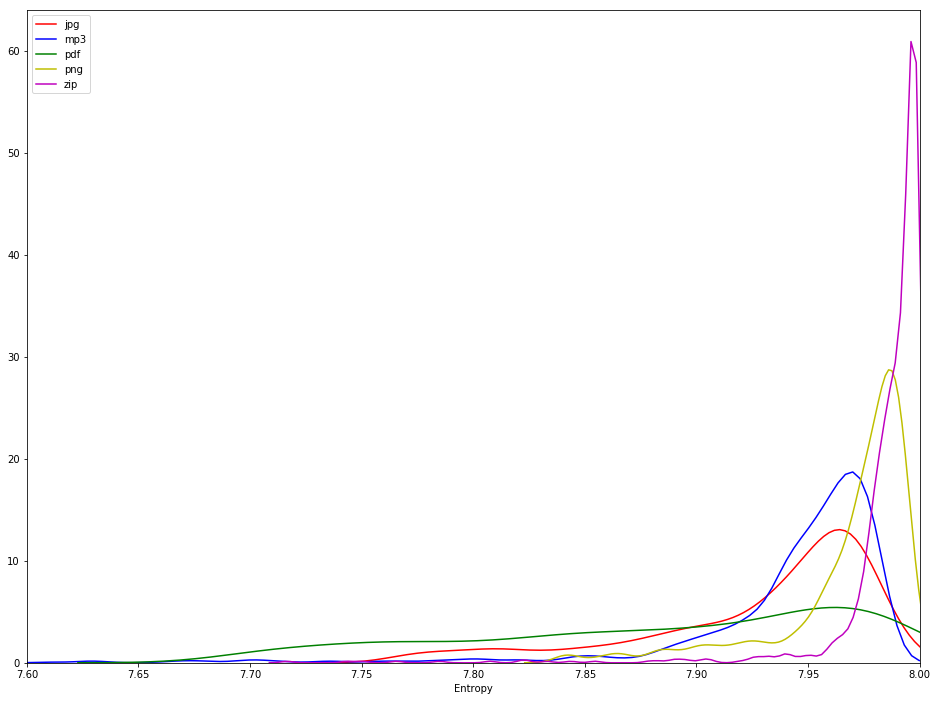

In [11]:
plotDistributionAttribute('Entropy', 7.6, 8)

* zip entropy distribution has a low standard deviation, the entropy is centered around the maximum 8, there is an important kurtosis
* png entropy distribution has also a low standard deviation and a mean near the maximum, the standard deviation is a bit more important than for zip files, the kurtosis is also high but less than for the zip 

Zip and png are two compression formats which explain why the entropy is always closer to the maximum.
* mp3 and jpeg entropy distributions show a greater standard deviation, entropy is also concentrated near this maximum but is a little more spread with a negative kurtosis and a negative skewness
* pdf entropy distribution shows a negative kurtosis contrary to all other file types, the distribution of entropy is more spread

<h4> b. Chi-square </h4>

> Chi square distribution is used to determine the deviation of observed results from expected results; for example, determining if the outcomes of 10 coin tosses were acceptably random, or if there were potentially external factors that influenced the results. Substantial deviations from the expected values of truly random data indicate a lack of randomness.

>Since each byte in a file can have one of 256 possible values, we would expect a file of random data to have a very even distribution of byte values between 0 and 255 inclusive. We can use the chi square distribution to compare the actual distribution of values to the expected distribution of values and use that comparison to draw conclusions regarding the randomness of data.


> In our case we have 256 values and that translates into 255 degrees of freedom. Next, if we select p=0.05, i.e. we want to determine if the stream of bytes is random with 95% of certainty, then looking into some table we obtain critical value 293.24, rounded it is 300. When Chi square is below that value, then we accept null hypothesis, i.e. the data is random, otherwise we reject null hypothesis, i.e. the data isn't random.

> Lower chi values (< 300) with higher pi error (> .03%) are indicative of compression.  
> Higher chi values (> 300) with lower pi errors (< .03%) are indicative of encryption.

In [12]:
describeAttribute('Chi_square')

,Chi_square_jpg,Chi_square_mp3,Chi_square_pdf,Chi_square_png,Chi_square_zip
mean,11433.584275,7.426412e+05,1.412822e+05,1.301405e+04,2287.943991
std,23109.322077,2.192427e+06,3.176460e+05,4.995752e+04,5418.249763
min,318.215202,4.366983e+04,8.823298e+02,2.605258e+02,224.880459
25%,1738.958685,1.935876e+05,2.680575e+04,1.241132e+03,424.332459
50%,4168.399528,3.267062e+05,5.416200e+04,3.164127e+03,757.224615
75%,11308.864865,5.929257e+05,1.117071e+05,9.437639e+03,1776.350361
max,356282.662341,2.528651e+07,4.661441e+06,1.147716e+06,62970.547602
skew,6.566269,8.099815e+00,6.563258e+00,1.492738e+01,6.299277
kurtosis,66.597105,7.010884e+01,6.064575e+01,2.933722e+02,49.079821


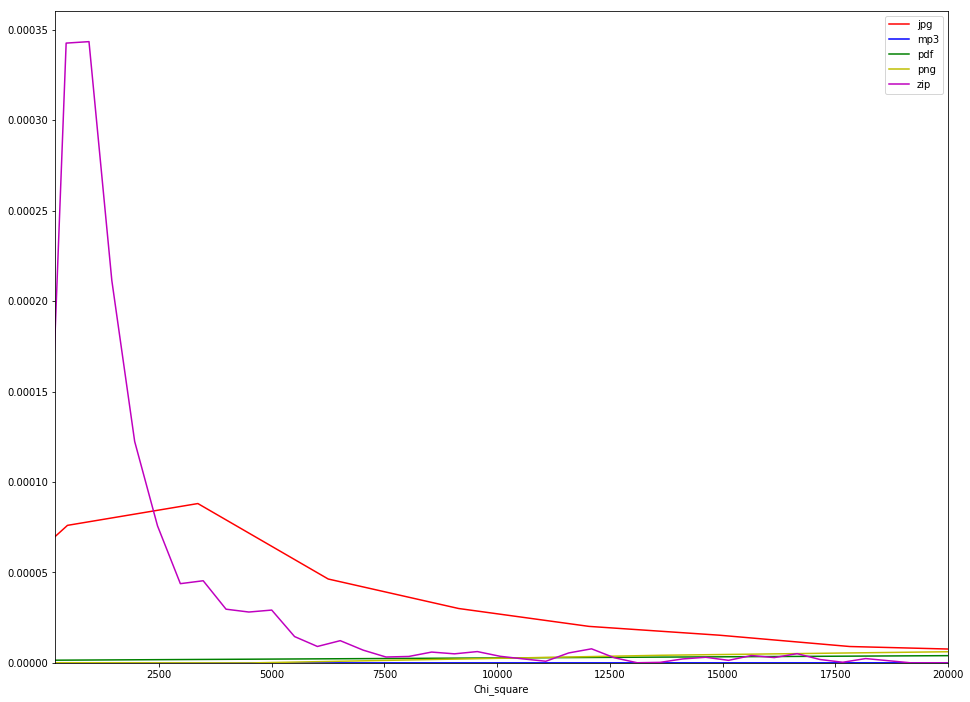

In [13]:
plotDistributionAttribute('Chi_square', 200, 2.0e+04)

* zip chi-square distribution show that most files have a very low chi-square which is expected for a compression format
* jpg files also have mostly a low chi-square but this is more distributed
* png files show a low mean chi-square but the standard deviation and the skewness are important
* For the other file types, the chi-square is higher when looking at the mean value but it is also very distributed as one can noticed with the standard deviation, especially for the mp3.

<h4> c. Monte Carlo pi approximation </h4>

> Each successive sequence of six bytes is used as 24 bit X and Y co-ordinates within a square. If the distance of the randomly-generated point is less than the radius of a circle inscribed within the square, the six-byte sequence is considered a “hit”. The percentage of hits can be used to calculate the value of Pi. For very large streams (this approximation converges very slowly), the value will approach the correct value of Pi if the sequence is close to random.

> Monte Carlo pi approximation  is used to approximate the value of pi from a given set of random (x,y) coordinates; the more unique well distributed data points, the closer the approximation should be to the actual value of pi. Very accurate pi approximations indicate a very random set of data points.

> Very accurate pi calculations (< .01% error) are sure signs of encryption.



In [14]:
describeAttribute('Monte_Carlo_Pi')

,Monte_Carlo_Pi_jpg,Monte_Carlo_Pi_mp3,Monte_Carlo_Pi_pdf,Monte_Carlo_Pi_png,Monte_Carlo_Pi_zip
mean,3.132395,3.169305,3.216731,3.110773,3.111973
std,0.113332,0.077971,0.112775,0.046686,0.051268
min,2.612035,2.912495,2.718736,2.790441,2.565631
25%,3.090320,3.122002,3.159924,3.087422,3.091047
50%,3.148330,3.163826,3.218661,3.109189,3.111378
75%,3.204455,3.210817,3.291864,3.133591,3.136040
max,3.513654,3.449399,3.604451,3.333215,3.322400
skew,-1.352494,0.381811,-0.768399,-0.373953,-2.091400
kurtosis,3.208018,0.590537,2.380297,5.312529,18.207205


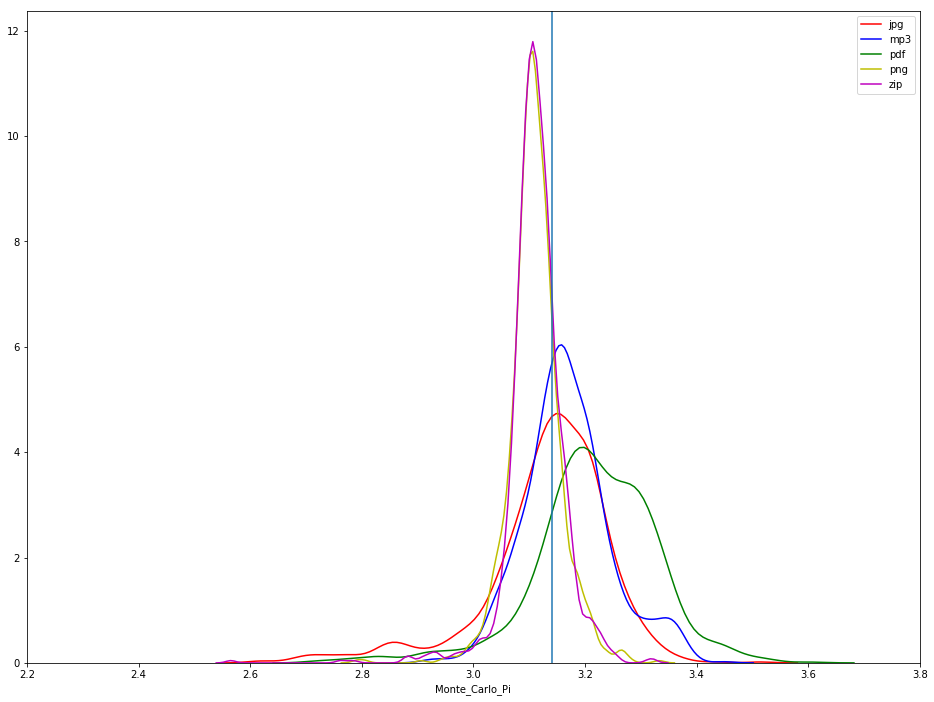

In [15]:
#adding this time a vertical line for pi
fig = plt.subplots(1,1, figsize=(16,12))
for i,f in enumerate(files) :
    ax1 = sns.distplot(f['Monte_Carlo_Pi'], color=colors[i], hist=False, kde=True, label=file_types[i])
ax1.set_xlim(2.2, 3.8)
plt.axvline(x=3.14159265358979323846)
plt.show()

* png and zip monte-carlo pi approximations have almost the same distribution, they are really centered with an important kurtosis, but not at the exact pi value as we could expect.
* mp3 and jpeg monte-carlo pi approximation distributions show a low kurtosis, they are centered around the actual value of pi.
* pdf files distribution is more spread with an important standard deviation.

<h4> d. Mean </h4>

> This is simply the result of summing the all the bytes (bits if the -b option is specified) in the file and dividing by the file length. If the data are close to random, this should be about 127.5 (0.5 for -b option output). If the mean departs from this value, the values are consistently high or low.

> Mean: if test source is long enough this value shouldn't be off by much; more than 10% off from 127.5 would be suspect (ie: > 140.25 or < 114.75)

In [16]:
describeAttribute('Mean')

,Mean_jpg,Mean_mp3,Mean_pdf,Mean_png,Mean_zip
mean,126.153098,123.942944,120.622939,127.679232,128.428503
std,4.527088,3.378010,5.842546,1.942252,1.897978
min,111.611159,107.283050,92.989800,116.872443,119.074209
25%,123.582687,122.707554,116.357174,126.788802,127.572417
50%,125.838940,124.527998,121.159780,127.798889,128.503762
75%,128.395008,125.918537,124.558811,128.711838,129.262628
max,144.863237,134.134176,137.156481,139.557750,147.058994
skew,0.668621,-1.405594,-0.131644,-0.214821,1.594897
kurtosis,2.012856,3.955308,0.263285,5.006744,15.116074


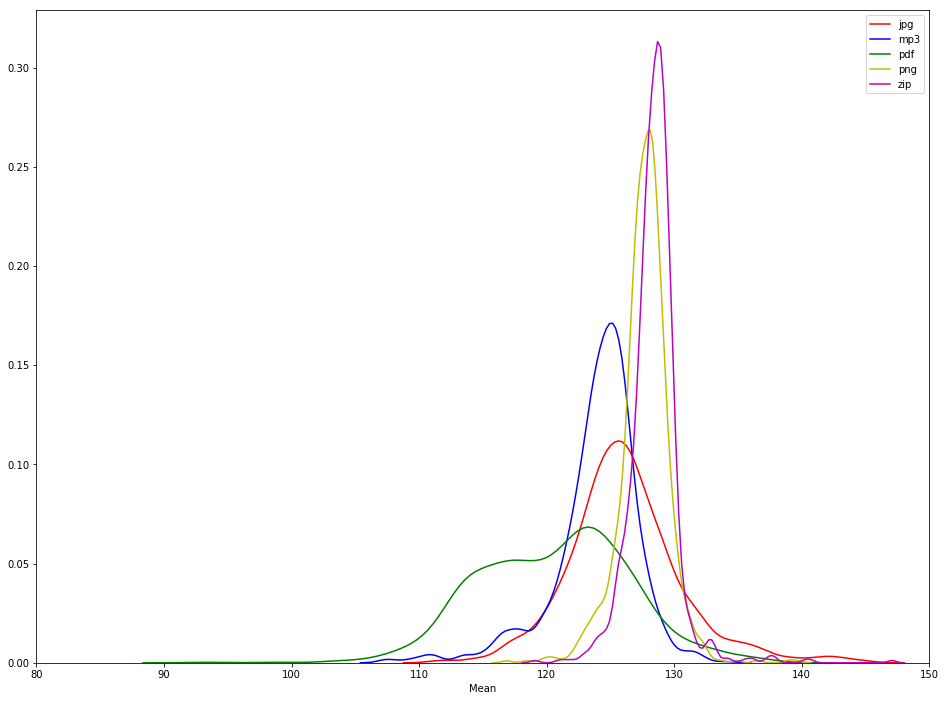

In [17]:
plotDistributionAttribute('Mean', 80, 150)

Once more a similar observation can be made.
* zip and png mean distribution have similar shape with an important kurtosis, but always a greater kurtosis for the zip distribution. 
* mp3 mean distribution has still an intermediate kurtosis between the ones for zip and png
* jpeg mean distribution has the second lower kurtosis after pdf
* pdf mean distribution is really skewed. 


<h4> e. Serial correlation </h4>

> This quantity measures the extent to which each byte in the file depends upon the previous byte. For random sequences, this value (which can be positive or negative) will, of course, be close to zero. A non-random byte stream such as a C program will yield a serial correlation coefficient on the order of 0.5. Wildly predictable data such as uncompressed bitmaps will exhibit serial correlation coefficients approaching 1. 

In [18]:
describeAttribute('Serial_Correlation')

,Serial_Correlation_jpg,Serial_Correlation_mp3,Serial_Correlation_pdf,Serial_Correlation_png,Serial_Correlation_zip
mean,0.049980,0.104703,0.101387,0.084576,0.009017
std,0.047601,0.039274,0.051708,0.059055,0.017726
min,-0.094433,0.030311,-0.084760,-0.104619,-0.093801
25%,0.016830,0.078382,0.061461,0.034408,0.001277
50%,0.040040,0.098388,0.099239,0.082098,0.008700
75%,0.074082,0.122198,0.140885,0.130261,0.017284
max,0.254598,0.273318,0.266762,0.278844,0.096479
skew,1.045505,1.329994,0.082664,0.283194,-0.132484
kurtosis,1.736708,2.610558,-0.542953,-0.292896,3.638427


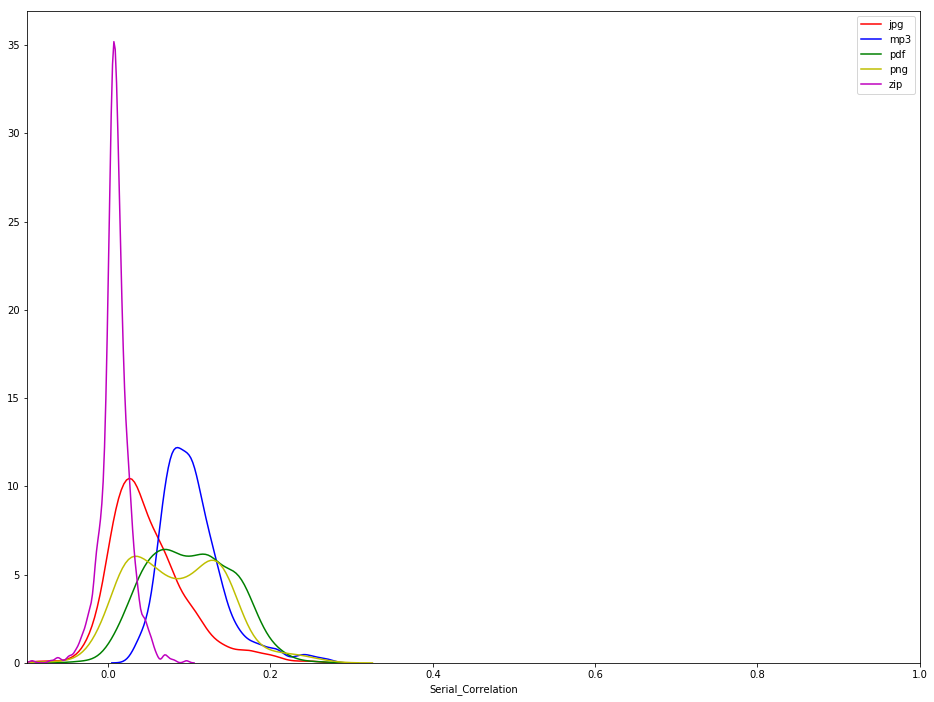

In [19]:
plotDistributionAttribute('Serial_Correlation', -0.1, 1)

This time the observation is different
* For the zip serial-correlation distribution, it does not change much : important kurtosis, no skewness. It is expected for a random sequence of a compressed file.
* Png serial-correlation distribution is not following anymore a similar shape as zip, it is not anymore centered, the standard deviation being important. Fortunately, this may allow the model to differentiate zip and png.
* mp3 serial-correlation distribution has still the same shape, though it is not centered around the 0 because there are relation between bytes.
* pdf serial-correlation distribution is close to the png one with an important standard deviation and low kurtosis as in every previous distribution.

<h4> f. Byte distribution </h4>

> Namely, by looking at the distribution of octets in a file you can know if it is encrypted or not. The point is that after encryption the file must look like a random sequence of bytes. So, every byte, from 0 to 255, will occur almost the same number of times in a file. 


> On the other hand, text files, images, and other files will have some bytes occurring more frequently than the others. For example, in text files space (0x20) occurs most frequently. So, the procedure is very easy, just count how many times each octet occurs in the file and then look at the differences. 

In [20]:
describeAttribute('0')

,0_jpg,0_mp3,0_pdf,0_png,0_zip
mean,0.015261,0.017688,0.005773,0.008934,0.004883
std,0.009294,0.013415,0.005036,0.006662,0.001747
min,0.002327,0.003225,0.000152,0.001680,0.001300
25%,0.009441,0.010664,0.003138,0.005750,0.003769
50%,0.012468,0.014160,0.003926,0.007356,0.004358
75%,0.018135,0.019372,0.006879,0.009203,0.005663
max,0.065621,0.104584,0.057096,0.053323,0.023147
skew,2.115601,3.485791,4.043907,3.275987,2.089283
kurtosis,5.737218,15.297579,26.283356,12.857350,12.036998


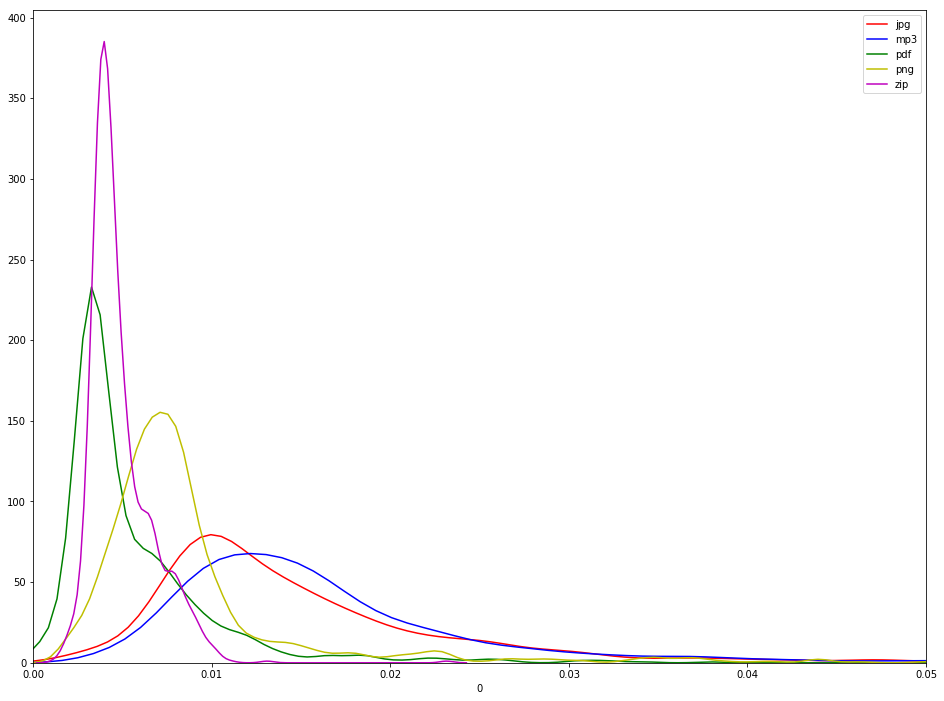

In [21]:
plotDistributionAttribute('0', 0, 0.05)

The distribution of the 0 byte is quite remarkable for pdf with regard to the previous distributions, it is more centered and has the greater kurtosis. We can expect the byte distribution to be more important features for the classifier than the statistical tests. 

In [22]:
def getFrequencies(statistic):
    '''statistic : string like std, mean, min, 25%...
    return a dataframe describing the statistic of byte distribution'''
    experiences = tests
    if 'File_type' in experiences:
        experiences.remove('File_type')
    rows = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
    assert statistic in rows
    rows.remove(statistic)
    df = pd.DataFrame(columns=[statistic + '_' + f['File_type'].iloc[0] for f in files])
    for f in files:
        col_name = statistic + '_' + f['File_type'].iloc[0]
        stats = f.describe().drop(experiences, axis=1)
        df[col_name] = stats.drop(rows).transpose()[statistic]
    return df    

In [23]:
mean = getFrequencies('mean')
display(mean.head())

,mean_jpg,mean_mp3,mean_pdf,mean_png,mean_zip
0,0.015261,0.017688,0.005773,0.008934,0.004883
1,0.005370,0.004327,0.003482,0.004313,0.003825
2,0.004377,0.004500,0.003327,0.004118,0.003702
3,0.004401,0.004043,0.003468,0.003717,0.003966
4,0.003979,0.005125,0.003520,0.004244,0.003750


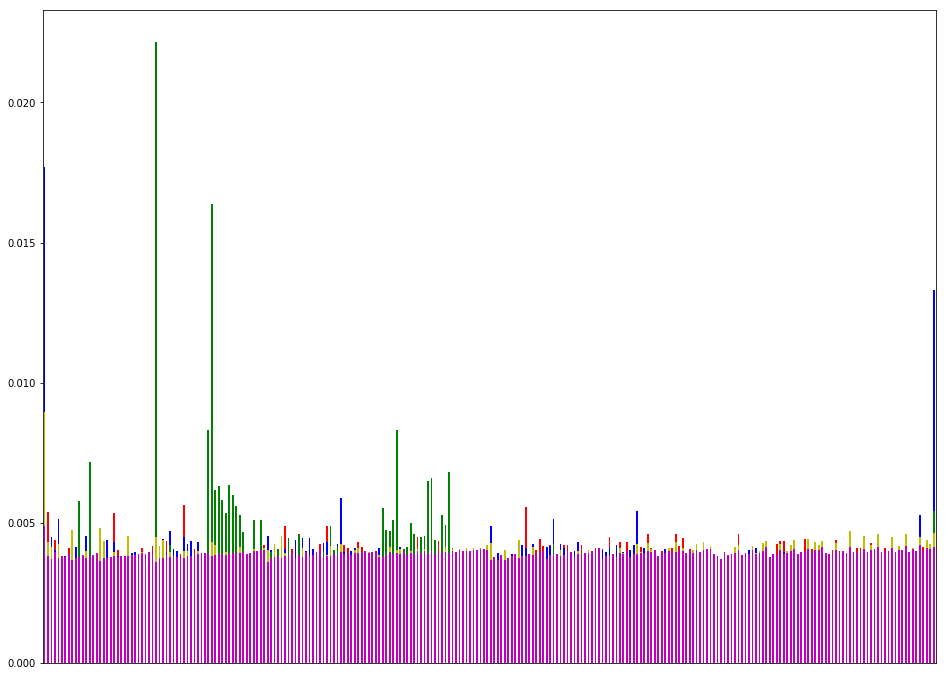

In [24]:
fig = plt.subplots(1,1, figsize=(16,12))
for i,col in enumerate(mean.columns):
    mean[col].plot(kind='bar', ax=plt.gca(), color=colors[i], label=file_types[i]) #label is not working but same color as before
plt.xticks([])
plt.show()

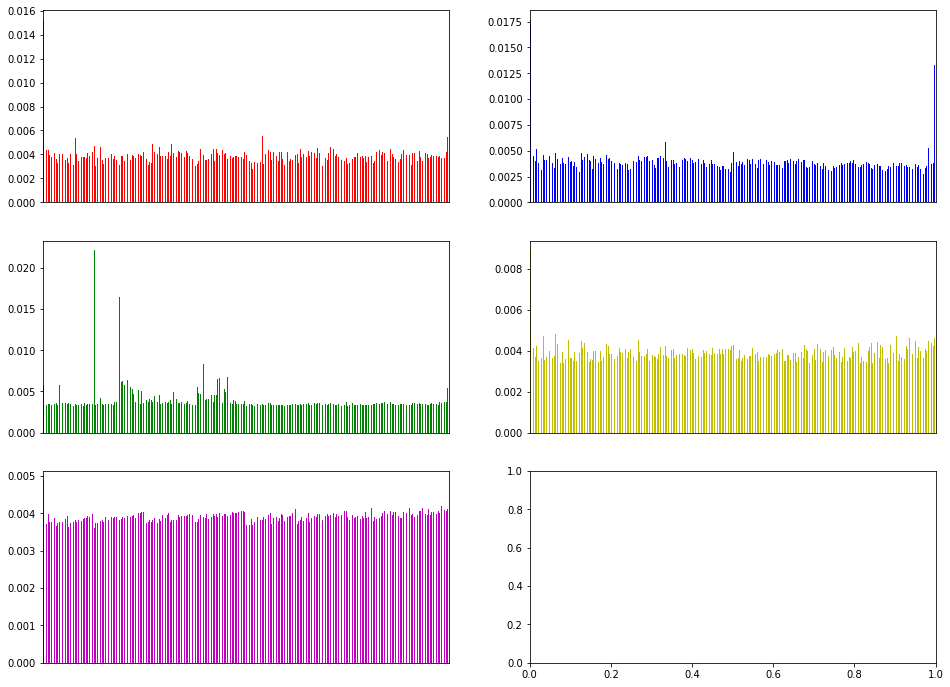

In [25]:
fig , ((ax1, ax2), (ax3, ax4), (ax5, ax6 )) = plt.subplots(3,2, figsize=(16,12))
axes = [ax1, ax2, ax3, ax4, ax5]
for i,col in enumerate(mean.columns):
    mean[col].plot(kind='bar', ax=axes[i], color=colors[i], label=file_types[i]) #label is not working but same color as before
    axes[i].get_xaxis().set_visible(False)
    if i>4:
        break
plt.show()

All files except pdf files have almost uniform bytes distribution because of the randomness but still with some patterns that may be recognized by the classifier.